In [20]:
# utils functions

import pathlib
import shutil
import os
import time
import datetime
import numpy as np
import wandb
import tensorflow as tf
import matplotlib.pyplot as plt
import zipfile

from typing import List

def load_data(run, artifact_name = "phcd_paper_splits_tfds") -> List[tf.data.Dataset]:
    """
    Downloads datasets from a wandb artifact and loads them into a list of tf.data.Datasets.
    """

    artifact = run.use_artifact(f"master-thesis/{artifact_name}:latest")
    artifact_dir = pathlib.Path(
        f"./artifacts/{artifact.name.replace(':', '-')}"
    ).resolve()
    if not artifact_dir.exists():
        artifact_dir = artifact.download()
        artifact_dir = pathlib.Path(artifact_dir).resolve()

    # if tf.__version__ minor is less than 10, use
    # tf.data.experimental.load instead of tf.data.Dataset.load

    if int(tf.__version__.split(".")[1]) < 10:
        load_function = tf.data.experimental.load
    else:
        load_function = tf.data.Dataset.load
    
    output_list = []
    for split in ["train", "test", "val"]:
        ds = load_function(str(artifact_dir / split), compression="GZIP")
        output_list.append(ds)
    
    return output_list

def get_readable_class_labels(subset = 'phcd_paper'):
    if subset == 'phcd_paper':
        return ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c',
        'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
        'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C',
        'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
        'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'ą', 'ć', 'ę',
        'ł', 'ń', 'ó', 'ś', 'ź', 'ż', 'Ą', 'Ć', 'Ę', 'Ł', 'Ń', 'Ó', 'Ś',
        'Ź', 'Ż', '+', '-', ':', ';', '$', '!', '?', '@', '.']
    elif subset == 'uppercase':
        return ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 
        'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'Ą', 'Ć', 
        'Ę', 'Ł', 'Ń', 'Ó', 'Ś', 'Ź', 'Ż']
    elif subset == 'lowercase':
        return ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
        'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ą', 'ć',
        'ę', 'ł', 'ń', 'ó', 'ś', 'ź', 'ż']
    elif subset == 'numbers':
        return ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    elif subset == 'uppercase_no_diacritics':
        return ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
        'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
    elif subset == 'lowercase_no_diacritics':
        return ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
        'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

def calculate_accuracy_per_class(model, test_dataset, test_dataset_name):
    '''
    Calculates the accuracy per class for a given model and test dataset.

    Returns dict with class labels as keys and accuracy as values.
    '''
        
    y_pred = model.predict(test_dataset)
    y_pred = np.argmax(y_pred, axis=1)
    # get labels
    y_true = test_dataset.map(lambda x, y: y).as_numpy_iterator()
    y_true = np.concatenate(list(y_true))
    # calculate accuracy per class
    labels = get_readable_class_labels(test_dataset_name)
    class_accuracy = np.zeros(len(labels))
    for i, label in enumerate(labels):
        class_accuracy[i] = np.sum(y_pred[y_true == i] == i) / np.sum(y_true == i)
    return { label: acc for label, acc in zip(labels, class_accuracy) }
    

def plot_accuracy_per_class(class_accuracy_dict):
    plt.figure(figsize=(10, 5))
    labels = list(class_accuracy_dict.keys())
    class_accuracy = list(class_accuracy_dict.values())
    plt.bar(labels, class_accuracy)
    plt.xticks(labels)
    plt.xlabel("Class")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per class")
    plt.show()


def accuracy_table(class_accuracy_dict):
    labels = list(class_accuracy_dict.keys())
    class_accuracy = list(class_accuracy_dict.values())
    return wandb.Table(columns=["Class", "Accuracy"], data=list(zip(labels, class_accuracy)))

def get_number_of_classes(ds: tf.data.Dataset) -> int:
    """
    Returns the number of classes in a dataset.
    """
    labels_iterator= ds.map(lambda x, y: y).as_numpy_iterator()
    labels = np.concatenate(list(labels_iterator))
    return len(np.unique(labels))

def get_number_of_examples(ds: tf.data.Dataset) -> int:
    """
    Returns the number of examples in a dataset.
    """
    return sum(1 for _ in ds)

def preprocess_dataset(ds: tf.data.Dataset, batch_size: int, cache: bool = True) -> tf.data.Dataset:
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))  # normalize
    ds = ds.unbatch().batch(batch_size)
    if cache:
        ds = ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

def calculate_model_compressed_size_on_disk(path: str) -> int:
    compressed_path = path + ".zip"
    with zipfile.ZipFile(compressed_path, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(path)
    return pathlib.Path(compressed_path).stat().st_size    

def calculate_model_size_on_disk(path: str) -> int:
    return pathlib.Path(path).stat().st_size

def calculate_model_num_parameters(model: tf.keras.Model) -> int:
    return model.count_params()

def calculate_model_flops(summary) -> float:
    # from run.summary get GFLOPs or GFLOPS whichever is available
    if "GFLOPs" in summary.keys():
        return summary.get("GFLOPs")
    elif "GFLOPS" in summary.keys():
        return summary.get("GFLOPS")
    else:
        return 0

In [35]:
import wandb
import pandas as pd
import pathlib

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")



project_name = "master-thesis"
run_name = "architecture-1"

def get_runs(project_name, run_name):
    """
    Returns all runs with a given name in a given project.
    """
    api = wandb.Api()
    runs = api.runs(
        project_name, {
            "$and": [
                {"displayName": run_name},
                {"state": "finished"},
                {"tags": "phcd_paper_splits_tfds"}
                ]
            })
    return [run.id for run in runs]

def get_model_from_run(run_id, project_name="master-thesis"):
    # from project run_id artifacts get file_name
    api = wandb.Api()
    run = api.run(f"{project_name}/{run_id}")
    # download file config.yaml
    run.file("config.yaml").download(replace=True)
    artifact = run.file("model_baseline.h5").download(replace=True)
    model = tf.keras.models.load_model(artifact.name, compile=False)
    return model, pathlib.Path(artifact.name)

run_ids = get_runs(project_name, run_name)

In [22]:
defaults = dict(
    batch_size=32*2,
    epochs=60,    
    optimizer="adam"
)

artifact_base_name = "phcd_paper"
artifact_name = f"{artifact_base_name}_splits_tfds" # "phcd_paper_splits_tfds
run = wandb.init(project="master-thesis", job_type="optimization",  config=defaults, tags=["optimization"])

# hyperparameters
epochs = wandb.config.epochs
bs = wandb.config.batch_size

ds_train, ds_test, ds_val = load_data(run, artifact_name=artifact_name)

num_classes = get_number_of_classes(ds_val)

ds_train = preprocess_dataset(ds_train, batch_size=bs)
ds_val = preprocess_dataset(ds_val, batch_size=bs)
ds_test = preprocess_dataset(ds_test, batch_size=bs, cache=False)

wandb: Currently logged in as: gratkadlafana. Use `wandb login --relogin` to force relogin


wandb:   9 of 9 files downloaded.  
2023-03-17 22:18:38.404392: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-17 22:18:38.404414: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (wiktor-on-linux): /proc/driver/nvidia/version does not exist
2023-03-17 22:18:38.404988: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# before optimization

In [33]:
def benchmark(bench_model, bench_model_path, benech_dataset):
    test_loss, test_acc = bench_model.evaluate(benech_dataset)
    num_parameters = calculate_model_num_parameters(bench_model)
    compressed_disk_size = calculate_model_compressed_size_on_disk(bench_model_path)

    print(f"Test accuracy: {test_acc}")
    
    print(f"Number of parameters: {num_parameters}")
    print(f"Compressed disk size (MB): {compressed_disk_size / 1e6}")
    return test_acc, num_parameters, compressed_disk_size

def plot_results(acc, num_params, dsk_size):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    data = [acc, num_params, dsk_size]
    # boxplots
    for i, ax in enumerate(axes.flatten()):
        # draw boxplot with seaborn
        sns.boxplot(data[i], ax=ax)
        # add title
        ax.set_title(f"{['Accuracy', 'Number of parameters', 'Compressed disk size'][i]}")

    # super title
    fig.suptitle("Pruning results - accuracy, # of parameters, compressed disk size", fontsize=16)

In [30]:
run_ids[0]

't7x4xuzk'

In [39]:
import tensorflow_model_optimization as tfmot
import tqdm
base_accuracies = []
base_num_parameters = []
base_compressed_disk_sizes = []

accuracies = []
num_parameters = []
compressed_disk_sizes = []

run_ids = run_ids[:2]
for run_id in tqdm.tqdm(run_ids):
  model, model_path = get_model_from_run(run_id, project_name)

  prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
  quantize_model = tfmot.quantization.keras.quantize_model


  prune_epochs = 2
  pruning_params = {
        #'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=0, frequency=100),
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.40, final_sparsity=0.80, begin_step=0, end_step=prune_epochs)
    }

  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()
  ]


  model.compile(
        optimizer="adam",
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
  
  base_acc, base_num_param, base_compressed_disk_size = benchmark(model, str(model_path), ds_test) 
  base_accuracies.append(base_acc)
  base_num_parameters.append(base_num_param)
  base_compressed_disk_sizes.append(base_compressed_disk_size)

  print("Base model accuracy: ", base_acc)
  break


  model_sparse = prune_low_magnitude(model, **pruning_params)
  model_sparse.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy'])

  model_sparse.fit(
      ds_train,
      epochs=prune_epochs,
      validation_data=ds_val,
      callbacks=[
        tfmot.sparsity.keras.UpdatePruningStep(),
    ]
  )

  tf.keras.models.save_model(model_sparse, 'model_sparse.h5', include_optimizer=False)

  test_acc, num_param, compressed_disk_size = benchmark(model_sparse, 'model_sparse.h5', ds_test)
 

  accuracies.append(test_acc)
  num_parameters.append(num_param)
  compressed_disk_sizes.append(compressed_disk_size)

  0%|          | 0/2 [00:00<?, ?it/s]

      8/Unknown - 0s 8ms/step - loss: 0.1478 - accuracy: 0.9590  

/home/wiktor/.pyenv/versions/3.10.9/envs/master-thesis/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1744/1744 [==============================] - 13s 7ms/step - loss: 0.1792 - accuracy: 0.9616


  0%|          | 0/2 [00:19<?, ?it/s]

Test accuracy: 0.9616191387176514
Number of parameters: 13831385
Compressed disk size (MB): 51.863803
Base model accuracy:  0.9616191387176514


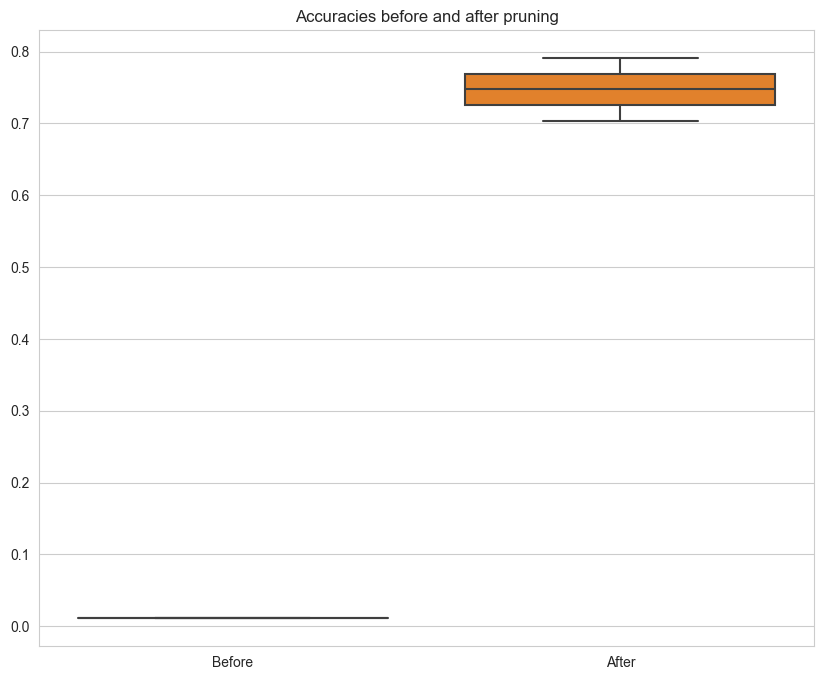

In [25]:
import numpy as np
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.boxplot([base_accuracies, accuracies], ax=ax)

ax.set_title('Accuracies before and after pruning')
ax.set_xticklabels(['Before', 'After'])
plt.show()

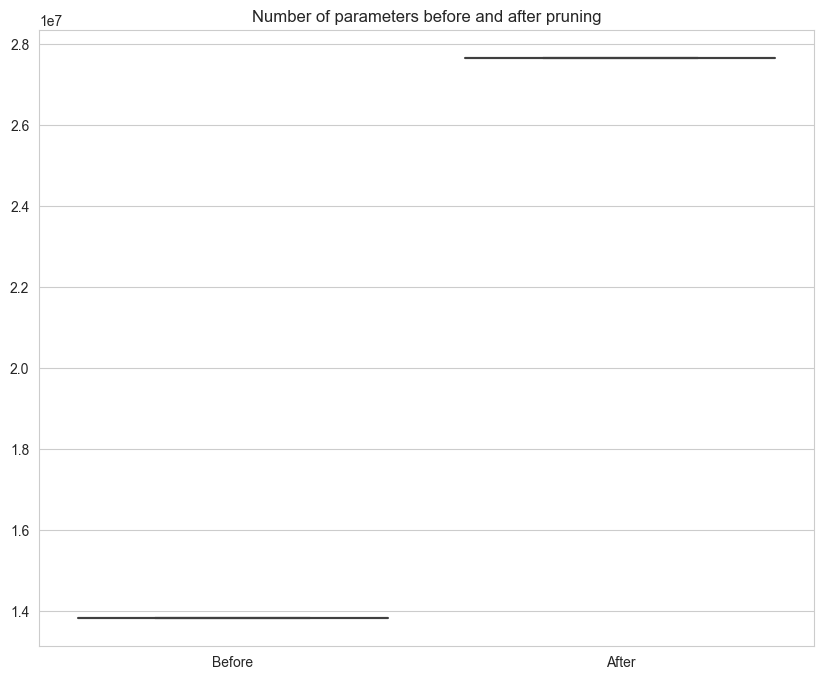

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.boxplot([base_num_parameters, num_parameters], ax=ax)

ax.set_title('Number of parameters before and after pruning')
ax.set_xticklabels(['Before', 'After'])
plt.show()

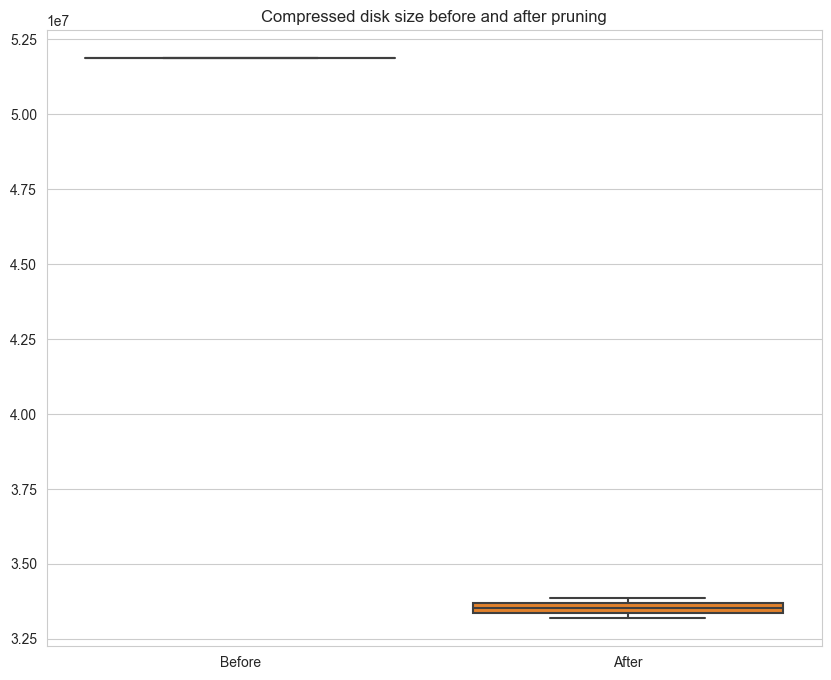

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.boxplot([base_compressed_disk_sizes, compressed_disk_sizes], ax=ax)

ax.set_title('Compressed disk size before and after pruning')
ax.set_xticklabels(['Before', 'After'])
plt.show()

In [ ]:
results = pd.DataFrame({
    "base_accuracy": base_accuracies,
    "accuracy": accuracies,
    "num_parameters": num_parameters,
    "compressed_disk_size": compressed_disk_sizes
})

results.to_csv("pruning_results_arch_1.csv")